In [1]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# Modeling
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Debug = False

# Read data
NROWS = 20000000
if Debug is True: NROWS = 5000
train = pd.read_csv('../../Taxi_trip_google_cloud/train.csv.zip',nrows = NROWS, index_col = "key")
train = train.dropna()
test_df = pd.read_csv('test.csv', index_col = "key")
testdex = test_df.index

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
# I actually think this function is flawed since it converts low magnitude decimal variables into intergers, rounding them.
# Reduce Memory..
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def prepare_distance_features(df):
    # Distance is expected to have an impact on the fare
    df['longitude_distance'] = abs(df['pickup_longitude'] - df['dropoff_longitude'])
    df['latitude_distance'] = abs(df['pickup_latitude'] - df['dropoff_latitude'])

    # Straight distance
    df['distance_travelled'] = (df['longitude_distance'] ** 2 + df['latitude_distance'] ** 2) ** .5
    df['distance_travelled_sin'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5)
    df['distance_travelled_cos'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5)
    df['distance_travelled_sin_sqrd'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5) ** 2
    df['distance_travelled_cos_sqrd'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5) ** 2

    # Haversine formula for distance
    # Haversine formula:	a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    R = 6371e3 # Metres
    phi1 = np.radians(df['pickup_latitude'])
    phi2 = np.radians(df['dropoff_latitude'])
    phi_chg = np.radians(df['pickup_latitude'] - df['dropoff_latitude'])
    delta_chg = np.radians(df['pickup_longitude'] - df['dropoff_longitude'])
    a = np.sin(phi_chg / 2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_chg / 2)
    c = 2 * np.arctan2(a ** .5, (1-a) ** .5)
    d = R * c
    df['haversine'] = d

    # Bearing
    # Formula:	θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
    y = np.sin(delta_chg * np.cos(phi2))
    x = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(delta_chg)
    df['bearing'] = np.arctan2(y, x)

    return df

def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.replace(" UTC", "")
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df['hour_of_day'] = df.pickup_datetime.dt.hour
    df['week'] = df.pickup_datetime.dt.week
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df['day_of_year'] = df.pickup_datetime.dt.dayofyear
    df['week_of_year'] = df.pickup_datetime.dt.weekofyear
    df["weekday"] = df.pickup_datetime.dt.weekday
    df["quarter"] = df.pickup_datetime.dt.quarter
    df["day_of_month"] = df.pickup_datetime.dt.day
    
    return df

# Percentile
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Build ime Aggregate Features
def time_agg(train, test_df, vars_to_agg, vars_be_agg):
    for var in vars_to_agg:
        agg = train.groupby(var)[vars_be_agg].agg(["sum","mean","std","skew",percentile(80),percentile(20)])
        if isinstance(var, list):
            agg.columns = pd.Index(["fare_by_" + "_".join(var) + "_" + str(e) for e in agg.columns.tolist()])
        else:
            agg.columns = pd.Index(["fare_by_" + var + "_" + str(e) for e in agg.columns.tolist()]) 
        train = pd.merge(train,agg, on=var, how= "left")
        test_df = pd.merge(test_df,agg, on=var, how= "left")
    
    return train, test_df

# Clean dataset from https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares
def clean_df(df):
    return df[(df.fare_amount > 0) & 
            (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45)]
print("Cleaning Functions Defined..")

Cleaning Functions Defined..


In [4]:
%%time
print("Percent of Training Set with Zero and Below Fair: ", round(((train.loc[train["fare_amount"] <= 0, "fare_amount"].shape[0]/train.shape[0]) * 100),5))
print("Percent of Training Set 200 and Above Fair: ", round((train.loc[train["fare_amount"] >= 200, "fare_amount"].shape[0]/train.shape[0]) * 100,5))
train = train.loc[(train["fare_amount"] > 0) & (train["fare_amount"] <= 200),:]
print("\nPercent of Training Set with Zero and Below Passenger Count: ", round((train.loc[train["passenger_count"] <= 0, "passenger_count"].shape[0]/train.shape[0]) * 100,5))
print("Percent of Training Set with Nine and Above Passenger Count: ", round((train.loc[train["passenger_count"] >= 9, "passenger_count"].shape[0]/train.shape[0]) * 100,5))
train = train.loc[(train["passenger_count"] > 0) & (train["passenger_count"] <= 9),:]

# Clean Training Set
train = clean_df(train)

# Distance Features
train = prepare_distance_features(train)
test_df = prepare_distance_features(test_df)

# Time Features
train = prepare_time_features(train)
test_df = prepare_time_features(test_df)

# Ratios
train["fare_to_dist_ratio"] = train["fare_amount"] / ( train["distance_travelled"]+0.0001)
train["fare_npassenger_to_dist_ratio"] = (train["fare_amount"] / train["passenger_count"]) /( train["distance_travelled"]+0.0001)

# Time Aggregate Features
train, test_df = time_agg(train, test_df,
                          vars_to_agg  = ["passenger_count", "weekday", "quarter", "month", "year", "hour_of_day",
                                          ["weekday", "month", "year"], ["hour_of_day", "weekday", "month", "year"]],
                          vars_be_agg = "fare_amount")

Percent of Training Set with Zero and Below Fair:  0.00688
Percent of Training Set 200 and Above Fair:  0.00371

Percent of Training Set with Zero and Below Passenger Count:  0.35304
Percent of Training Set with Nine and Above Passenger Count:  0.00013
CPU times: user 3min 58s, sys: 2min 43s, total: 6min 42s
Wall time: 6min 42s


In [5]:
train_time_start = train.pickup_datetime.min()
train_time_end = train.pickup_datetime.max()
print("Train Time Starts: {}, Ends {}".format(train_time_start,train_time_end))
test_time_start = test_df.pickup_datetime.min()
test_time_end = test_df.pickup_datetime.max()
print("Test Time Starts: {}, Ends {}".format(test_time_start,test_time_end))

Train Time Starts: 2009-01-01 00:00:46, Ends 2015-06-30 23:59:54
Test Time Starts: 2009-01-01 11:04:24, Ends 2015-06-30 20:03:50


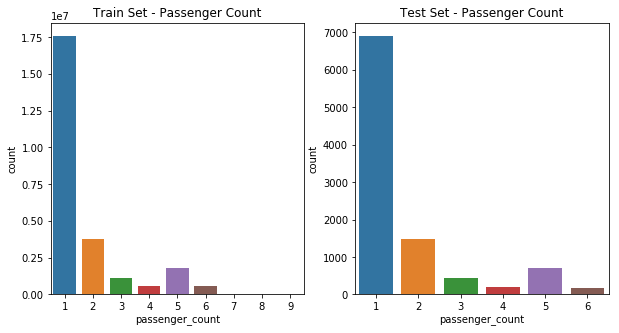

In [6]:
f, ax = plt.subplots(1,2,figsize = [10,5])
sns.countplot(train["passenger_count"], ax=ax[0])
sns.countplot(test_df["passenger_count"], ax=ax[1])
ax[0].set_title("Train Set - Passenger Count")
ax[1].set_title("Test Set - Passenger Count")
plt.show()

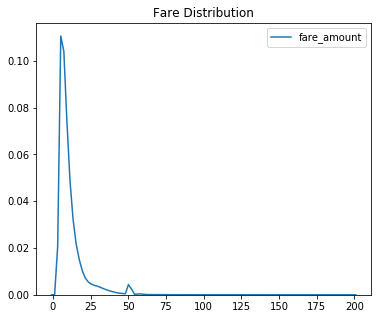

In [7]:
f, ax = plt.subplots(figsize=[6,5])
sns.kdeplot(train["fare_amount"], ax=ax)
ax.set_title("Fare Distribution")
plt.show()

In [8]:
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [14,10])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)

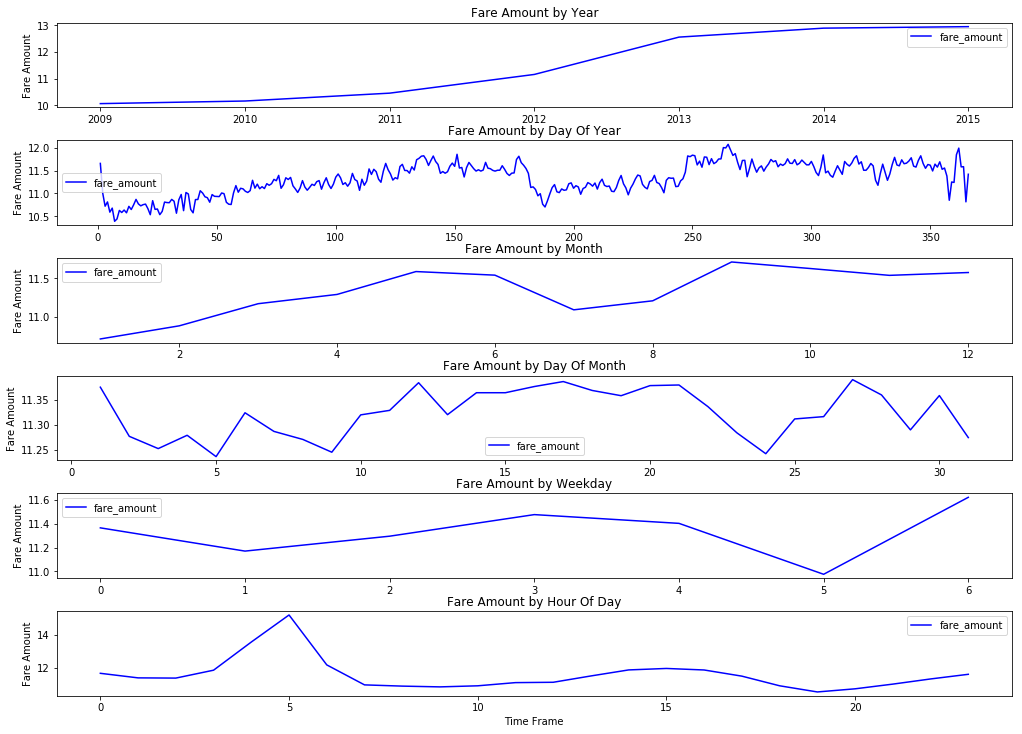

In [9]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "fare_amount", color="blue")

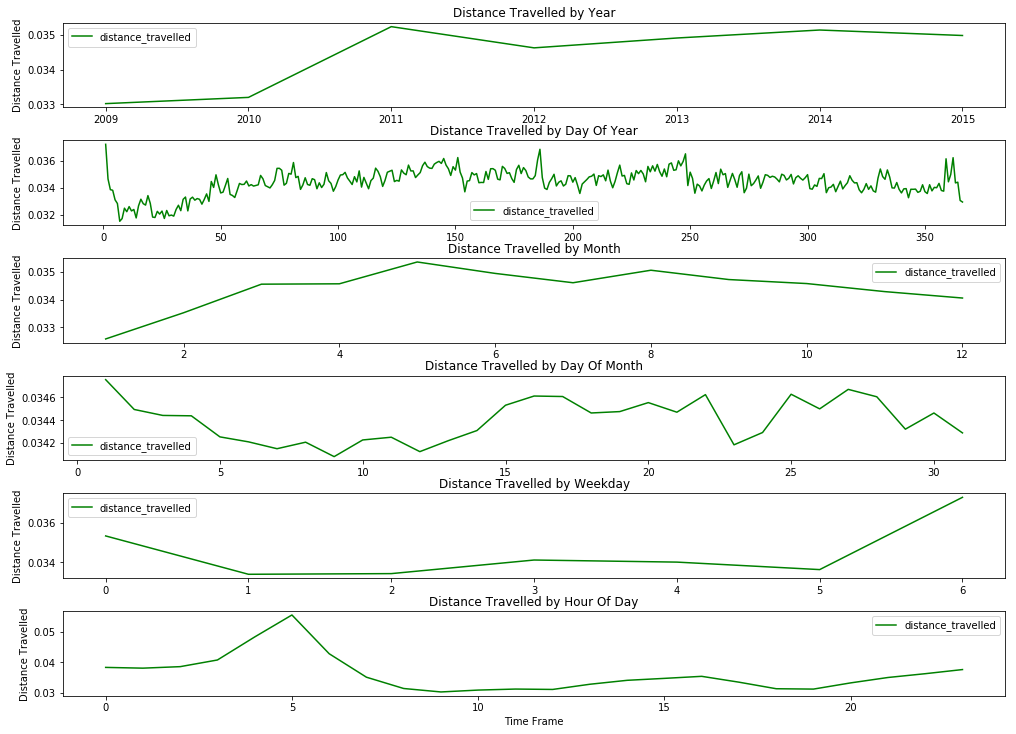

In [10]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "distance_travelled", color = "green")


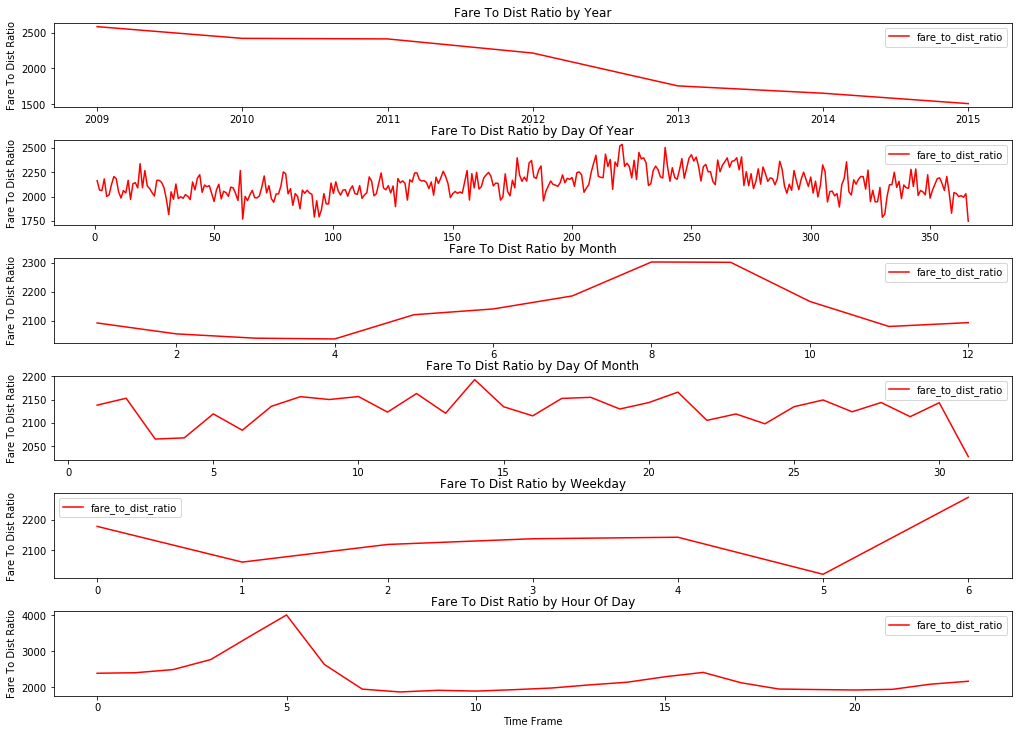

In [11]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "fare_to_dist_ratio", color = "red")


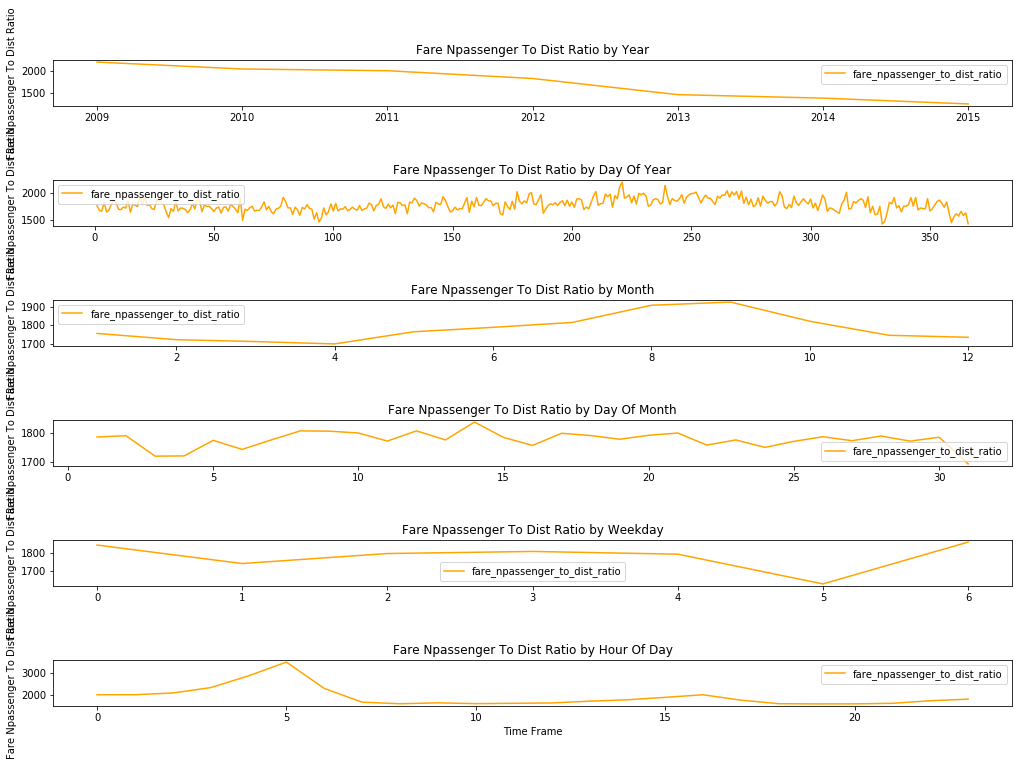

In [12]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "fare_npassenger_to_dist_ratio", color = "orange")


In [13]:
# Keep Relevant Variables..
y = np.log(train['fare_amount'].values + 1)
#y = train.fare_amount.copy()
test_df.drop("pickup_datetime", axis = 1, inplace=True)
train = train[test_df.columns]
print("Does Train feature equal test feature?: ", all(train.columns == test_df.columns))
trainshape = train.shape
testshape = test_df.shape

# print("\nTrain DF..")
# train = reduce_mem_usage(train)
# print("\nTest DF..")
# test_df = reduce_mem_usage(test_df)

# LGBM Dataset Formating
dtrain = lgb.Dataset(train, label=y, free_raw_data=False)

Does Train feature equal test feature?:  True


In [14]:
print("Light Gradient Boosting Regressor: ")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse'
                }

folds = KFold(n_splits=3, shuffle=True, random_state=1)
fold_preds = np.zeros(testshape[0])
oof_preds = np.zeros(trainshape[0])
dtrain.construct()

# Fit 5 Folds
modelstart = time.time()
for trn_idx, val_idx in folds.split(train):
    clf = lgb.train(
        params=lgbm_params,
        train_set=dtrain.subset(trn_idx),
        valid_sets=dtrain.subset(val_idx),
        num_boost_round=3500, 
        early_stopping_rounds=125,
        verbose_eval=500
    )
    oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
    fold_preds += (np.exp(clf.predict(test_df)) - 1) / folds.n_splits


Light Gradient Boosting Regressor: 
Training until validation scores don't improve for 125 rounds.
[500]	valid_0's rmse: 0.203327
[1000]	valid_0's rmse: 0.200994
[1500]	valid_0's rmse: 0.199874
[2000]	valid_0's rmse: 0.199064
[2500]	valid_0's rmse: 0.198555
[3000]	valid_0's rmse: 0.198088
[3500]	valid_0's rmse: 0.197832
Did not meet early stopping. Best iteration is:
[3500]	valid_0's rmse: 0.197832
Training until validation scores don't improve for 125 rounds.
[500]	valid_0's rmse: 0.203402
[1000]	valid_0's rmse: 0.200857
[1500]	valid_0's rmse: 0.199698
[2000]	valid_0's rmse: 0.199072
[2500]	valid_0's rmse: 0.19854
[3000]	valid_0's rmse: 0.198101
[3500]	valid_0's rmse: 0.197774
Did not meet early stopping. Best iteration is:
[3499]	valid_0's rmse: 0.197774
Training until validation scores don't improve for 125 rounds.
[500]	valid_0's rmse: 0.203028
[1000]	valid_0's rmse: 0.200642
[1500]	valid_0's rmse: 0.19944
[2000]	valid_0's rmse: 0.198626
[2500]	valid_0's rmse: 0.198149
[3000]	valid

In [15]:
lgsub = pd.DataFrame(fold_preds,columns=["fare_amount"],index=testdex)
lgsub.to_csv("lgsub12.csv",index=True,header=True)


In [16]:
lgsub

,fare_amount
key,
2015-01-27 13:08:24.0000002,8.604495
2015-01-27 13:08:24.0000003,9.493114
2011-10-08 11:53:44.0000002,4.455191
2012-12-01 21:12:12.0000002,9.137073
2012-12-01 21:12:12.0000003,15.909051
2012-12-01 21:12:12.0000005,9.721728
2011-10-06 12:10:20.0000001,5.416777
2011-10-06 12:10:20.0000003,49.448799
2011-10-06 12:10:20.0000002,11.157114
